# RDS2 EDA - Разведочный анализ данных
  Отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет
  на их успеваемость по математике, чтобы на ранней стадии выявлять студентов,
  находящихся в группе риска.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
%matplotlib inline

pd.set_option('display.max_rows', 400)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

data = pd.read_csv('stud_math.csv')
stud = data.copy()

In [2]:
# Первичная обработка данных
# Рассмотрим, какие данные хранятся в файле и какие типы данных у столбцов:
display(stud.head(10))
stud.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj


# Посмотрим на переменные, которые содержит датасет:

1 school — аббревиатура школы, в которой учится ученик

2 sex — пол ученика ('F' - женский, 'M' - мужской)

3 age — возраст ученика (от 15 до 22)

4 address — тип адреса ученика ('U' - городской, 'R' - за городом)

5 famsize — размер семьи('LE3' <= 3, 'GT3' >3)

6 Pstatus — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

7 Medu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

8 Fedu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

9 Mjob — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

10 Fjob — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

11 reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)

12 guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)

13 traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

14 studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

15 failures — количество внеучебных неудач (n, если 1<=n<=3, иначе 0)

16 schoolsup — дополнительная образовательная поддержка (yes или no)

17 famsup — семейная образовательная поддержка (yes или no)

18 paid — дополнительные платные занятия по математике (yes или no)

19 activities — дополнительные внеучебные занятия (yes или no)

20 nursery — посещал детский сад (yes или no)

21 higher — хочет получить высшее образование (yes или no)

22 internet — наличие интернета дома (yes или no)

23 romantic — в романтических отношениях (yes или no)

24 famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)

25 freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого)

26 goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)

27 health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)

28 absences — количество пропущенных занятий

29 score — баллы по госэкзамену по математике

# Первые выводы
Датасет содержит: 395 строк, 30 столбцов 
    
Есть столбец **studytime, granula**, отсутствующий в описании датасета

Столбы: school, sex, age - без пропусков
    

Количественные переменные - 6: age, traveltime, studytime, failures, absences, score

Качественные переменные - 

    - номинальные - 17: school, sex, address, famsize, Pstatus, Mjob, Fjob, reason, guardian,
        
                schoolsup, famsup, paid, activities, nursery, higher, internet, romantic 
    
    - порядковые - 6: Medu, Fedu, famrel, freetime, goout, health      

# Функции обработки столбцов

In [3]:
# Функция проверки на выбросы
def outliers(df, col):
    # Межквартильный размах
    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
    perc25 = df[col].quantile(0.25)
    perc75 = df[col].quantile(0.75)
    range_s = df[col].min()  # Границы столбца
    range_e = df[col].max()

    print(
        '25-й перцентиль: {},'.format(perc25),
        '75-й перцентиль: {},'.format(perc75),
        "IQR: {}, ".format(IQR),
        "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

    df[col].loc[df[col].between(
        perc25 - 1.5*IQR,
        perc75 + 1.5*IQR)].hist(bins=16, range=(range_s, range_e), label='В границах выбросов')

    df[col].hist(
        alpha=0.9, bins=16, range=(range_s, range_e), label='Все значения')

    df[col].loc[(df[col] >= (perc25 - 1.5*IQR)) & (df[col] <= (perc75 + 1.5*IQR))].hist(
        alpha=0.3, bins=16, range=(range_s, range_e), label='Без выбросов')

    plt.legend()
    print('Процентное соотношение значений столбца {}'.format(col))
    display(df[col].value_counts(normalize=True))

#  Функция подсчета уникальных значений и процент пустых значений


def uniq_nan(col):
    print("Уникальных значений {}:" .format(col), stud[col].nunique())
    print("Пустых значений {}:" .format(col),
          "{:.1%}" .format(stud[col].isnull().sum()/len(stud)))


# функция замены количественных переменных на качественные


def Quan_to_Qual(col):
    col = col.apply(lambda x: 'no' if x == 0
                    else 'yes')
    display(pd.DataFrame(col.value_counts()))
    print("Уникальных значений:", col.nunique())

# Функция построения боксплотов


def get_boxplot(col):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=col, y='score',
                data=stud.loc[stud.loc[:, col].isin(
                    stud.loc[:, col].value_counts().index[:])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot для ' + col)
    plt.show()

# функция проверки статистической разницы в распределении
# оценок по номинативным признакам, с помощью теста Стьюдента.


def get_stat_dif(col):
    cols = stud.loc[:, col].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(stud.loc[stud.loc[:, col] == comb[0], 'score'],
                     stud.loc[stud.loc[:, col] == comb[1], 'score']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', col)
            break

# Рассмотрим количественные переменные

In [4]:
uniq_nan('age')

Уникальных значений age: 8
Пустых значений age: 0.0%


25-й перцентиль: 16.0, 75-й перцентиль: 18.0, IQR: 2.0,  Границы выбросов: [13.0, 21.0].
Процентное соотношение значений столбца age


16    0.263291
17    0.248101
15    0.207595
18    0.207595
19    0.060759
20    0.007595
21    0.002532
22    0.002532
Name: age, dtype: float64

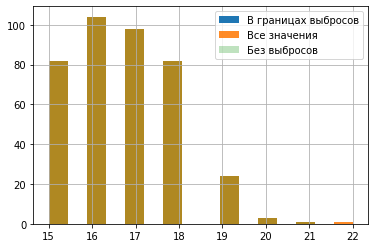

In [5]:
# age — возраст ученика (от 15 до 22)
# Этот столбец числовой и без пропусков, посмотрим на его распределение:
outliers(stud,'age')

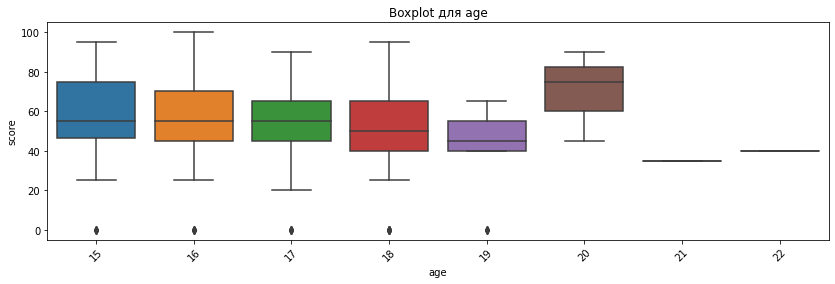

In [6]:
get_boxplot('age')

In [7]:
# Возраст 22 является выбросом
# Так, как по условию нужно  отследить влияние условий жизни
# учащихся в возрасте от 15 до 22 лет, то удалять этот выброс не стоит

Уникальных значений traveltime: 4
Пустых значений traveltime: 7.1%
25-й перцентиль: 1.0, 75-й перцентиль: 2.0, IQR: 1.0,  Границы выбросов: [-0.5, 3.5].
Процентное соотношение значений столбца traveltime


1.0    0.659401
2.0    0.261580
3.0    0.059946
4.0    0.019074
Name: traveltime, dtype: float64

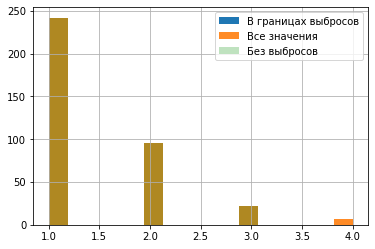

In [8]:
# traveltime - "время в пути до школы"
uniq_nan('traveltime')
outliers(stud, 'traveltime')

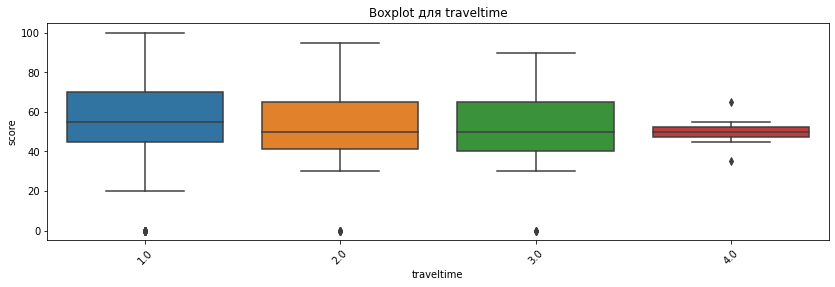

In [9]:
get_boxplot('traveltime')

In [10]:
# время в пути до школы > 60 мин является выбросом,
# количество учеников у которых путь занимает столько времении менее 2%

Уникальных значений studytime: 4
Пустых значений studytime: 1.8%
25-й перцентиль: 1.0, 75-й перцентиль: 2.0, IQR: 1.0,  Границы выбросов: [-0.5, 3.5].
Процентное соотношение значений столбца studytime


2.0    0.500000
1.0    0.265464
3.0    0.164948
4.0    0.069588
Name: studytime, dtype: float64

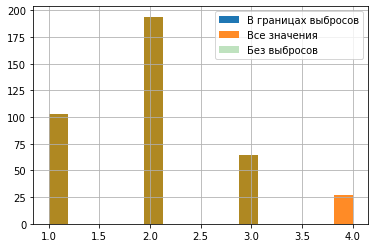

In [11]:
#  studytime — время на учёбу помимо школы в неделю
uniq_nan('studytime')
outliers(stud, 'studytime')

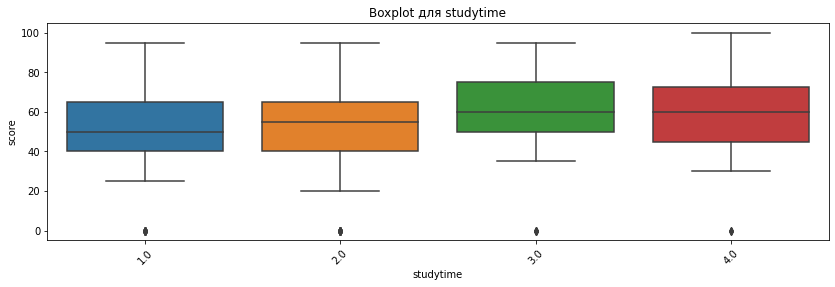

In [12]:
get_boxplot('studytime')

In [13]:
# время на учёбу > 10 часов в неделю является выбросом,
# количество таких учеников менее 7%

Уникальных значений failures: 4
Пустых значений failures: 5.6%
25-й перцентиль: 0.0, 75-й перцентиль: 0.0, IQR: 0.0,  Границы выбросов: [0.0, 0.0].
Процентное соотношение значений столбца failures


0.0    0.785523
1.0    0.131367
2.0    0.042895
3.0    0.040214
Name: failures, dtype: float64

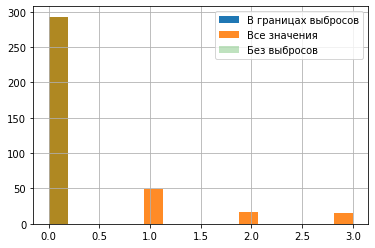

In [14]:
#  failures — количество внеучебных неудач (n, если 1<=n<=3, иначе 0)
uniq_nan('failures')
outliers(stud, 'failures')

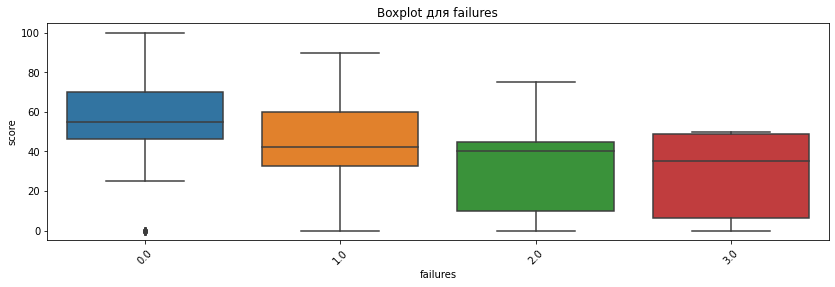

In [15]:
get_boxplot('failures')

In [16]:
# В этом случае формула определения выбросов не работает
# 79% учеников не испытывало внеучебных неудач, у 13 % была одна неудача, и по 4% приходится на 2 и 3 неудачи
# преобразуем количественную переменную failures в номинальную качественную
#  если 1<=n<=3, то - yes, иначе - no

In [17]:
Quan_to_Qual(stud.failures)

,failures
no,293
yes,102


Уникальных значений: 2


Уникальных значений absences: 36
Пустых значений absences: 3.0%
25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].
Процентное соотношение значений столбца absences


0.0      0.289817
2.0      0.156658
4.0      0.138381
6.0      0.080940
8.0      0.054830
10.0     0.044386
14.0     0.031332
12.0     0.031332
3.0      0.020888
16.0     0.018277
7.0      0.015666
18.0     0.013055
5.0      0.013055
20.0     0.010444
9.0      0.007833
22.0     0.007833
1.0      0.007833
13.0     0.005222
15.0     0.005222
11.0     0.005222
40.0     0.002611
38.0     0.002611
56.0     0.002611
23.0     0.002611
24.0     0.002611
25.0     0.002611
385.0    0.002611
17.0     0.002611
75.0     0.002611
21.0     0.002611
212.0    0.002611
28.0     0.002611
19.0     0.002611
26.0     0.002611
30.0     0.002611
54.0     0.002611
Name: absences, dtype: float64

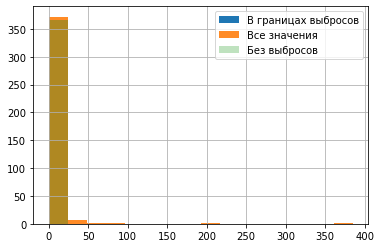

In [18]:
# absences — количество пропущенных занятий
uniq_nan('absences')
outliers(stud, 'absences')

In [19]:
# Ведем новую качественную номинальную переменную (low <= 20 пропусков, hihg > 20)
stud['absence_rate'] = stud.absences.apply(lambda x: 'high' if x > 20
                                           else 'low')

display(pd.DataFrame(stud['absence_rate'].value_counts()))
print("Уникальных значений:", stud['absence_rate'].nunique())

,absence_rate
low,378
high,17


Уникальных значений: 2


In [20]:
# Получается учеников, кто много пропускает

Уникальных значений score: 18
Пустых значений score: 1.5%
25-й перцентиль: 40.0, 75-й перцентиль: 70.0, IQR: 30.0,  Границы выбросов: [-5.0, 115.0].
Процентное соотношение значений столбца score


50.0     0.138817
55.0     0.118252
0.0      0.095116
75.0     0.084833
65.0     0.079692
60.0     0.079692
40.0     0.079692
45.0     0.069409
70.0     0.069409
80.0     0.041131
30.0     0.038560
90.0     0.030848
35.0     0.023136
25.0     0.017995
85.0     0.015424
95.0     0.012853
20.0     0.002571
100.0    0.002571
Name: score, dtype: float64

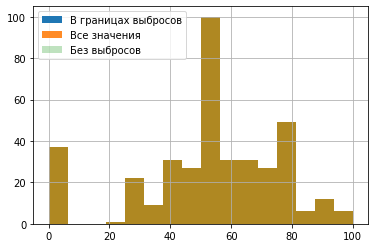

In [21]:
# score — баллы по госэкзамену по математике
uniq_nan('score')
outliers(stud, 'score')

In [22]:
print('Количество учеников, набраших {}'.format(
    stud.score[stud.score == 0].value_counts()), 'баллов')

Количество учеников, набраших 0.0    37
Name: score, dtype: int64 баллов


In [23]:
# Выбросов у предсказываемой величины нет
# Есть пропуски
# Посмотрим корреляцию с другими количественными признаками

In [24]:
# Удалим строки с пустыми зачениями
stud.dropna(subset=['score'], inplace=True)

In [25]:
uniq_nan('score')

Уникальных значений score: 18
Пустых значений score: 0.0%


#  Корреляционный анализ

In [26]:
Quanstud = stud[['age', 'traveltime', 'studytime',
                 'failures', 'studytime, granular', 'absences', 'score']]
Quanstud

,age,traveltime,studytime,failures,"studytime, granular",absences,score
0,18,2.0,2.0,0.0,-6.0,6.0,30.0
1,17,1.0,2.0,0.0,-6.0,4.0,30.0
2,15,1.0,2.0,3.0,-6.0,10.0,50.0
3,15,1.0,3.0,0.0,-9.0,2.0,75.0
4,16,1.0,2.0,0.0,-6.0,4.0,50.0
5,16,1.0,2.0,0.0,-6.0,10.0,75.0
6,16,1.0,2.0,0.0,-6.0,0.0,55.0
7,17,2.0,2.0,0.0,-6.0,6.0,30.0
8,15,1.0,2.0,0.0,-6.0,0.0,95.0
9,15,1.0,2.0,0.0,-6.0,0.0,75.0


<AxesSubplot:>

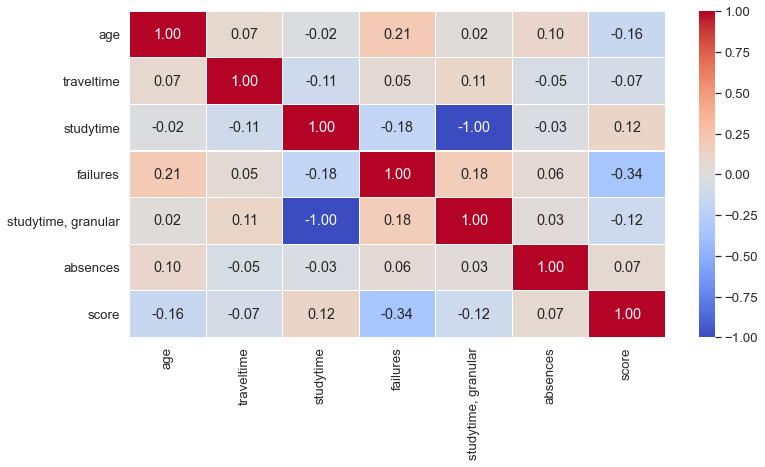

In [27]:
# Тепловая карта
sns.set(font_scale=1.2)
plt.subplots(figsize=(12, 6))
sns.heatmap(Quanstud.corr(), annot=True, fmt='.2f',
            linewidths=0.1, cmap="coolwarm")

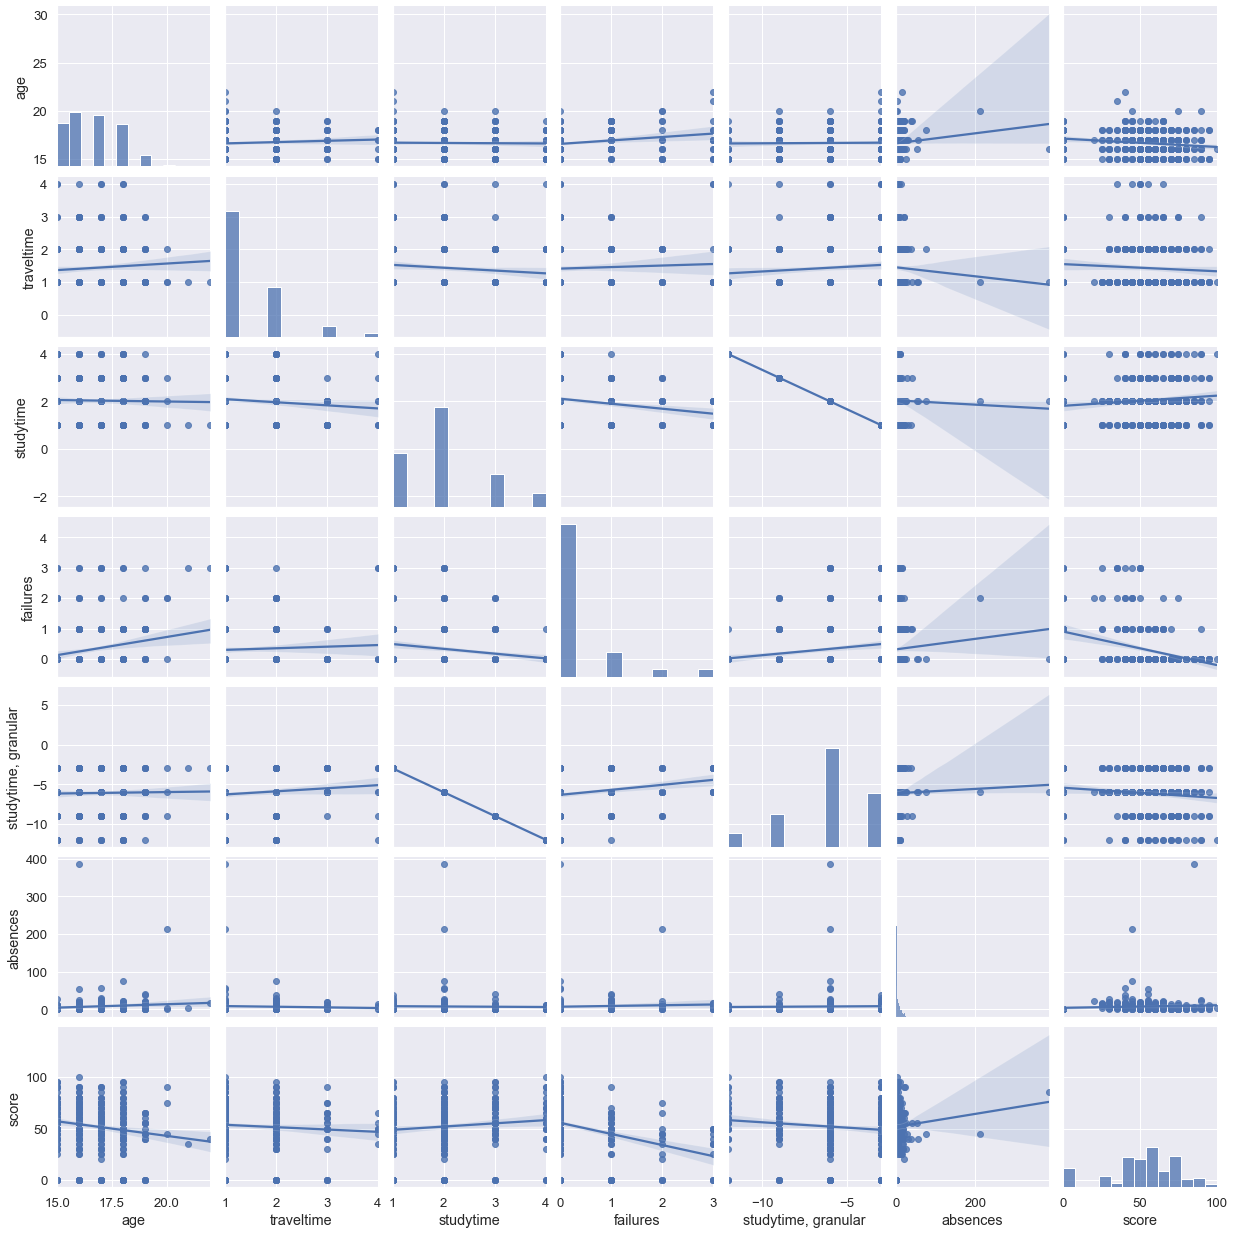

In [28]:
sns.pairplot(Quanstud, kind = 'reg')

In [30]:
Quanstud.corr()

,age,traveltime,studytime,failures,"studytime, granular",absences,score
age,1.000000,0.073146,-0.018227,0.205919,0.018227,0.096628,-0.155726
traveltime,0.073146,1.000000,-0.105910,0.049738,0.105910,-0.048242,-0.070559
studytime,-0.018227,-0.105910,1.000000,-0.181947,-1.000000,-0.025707,0.115741
failures,0.205919,0.049738,-0.181947,1.000000,0.181947,0.058166,-0.344338
"studytime, granular",0.018227,0.105910,-1.000000,0.181947,1.000000,0.025707,-0.115741
absences,0.096628,-0.048242,-0.025707,0.058166,0.025707,1.000000,0.065283
score,-0.155726,-0.070559,0.115741,-0.344338,-0.115741,0.065283,1.000000


In [31]:
# Есть обратная связь между неизвестным столбцом "studytime, granular" и studytime
# "studytime, granular" следует удалить как избыточный
stud.drop('studytime, granular', axis=1, inplace=True)

In [32]:
# Есть небольшая обратная корреляция с возрастом (age), и примерно в два раза
# больше обратная корреляция с количеством внеучебных неудач (failures)
# Также есть небольшая корредяция со временем на учёбу помимо школы в неделю (studytime)

# Список значимых столбцов
meaningful = ['age', 'failures', 'studytime']

# Рассмотрим качественные переменные

In [63]:
# В датасете есть - порядковые качественные переменные, записанные как числовые:
# Medu, Fedu, famrel, freetime, goout, health
# Можно также посмотреть их корреляцию с целевой переменной score

In [33]:
# Список порядковых качественных переменных
Ordinal = stud[['Medu', 'Fedu', 'famrel',
                'freetime', 'goout', 'health', 'score']]

In [34]:
for col in Ordinal:
    uniq_nan(col)

Уникальных значений Medu: 5
Пустых значений Medu: 0.8%
Уникальных значений Fedu: 6
Пустых значений Fedu: 6.2%
Уникальных значений famrel: 6
Пустых значений famrel: 6.9%
Уникальных значений freetime: 5
Пустых значений freetime: 2.3%
Уникальных значений goout: 5
Пустых значений goout: 1.8%
Уникальных значений health: 5
Пустых значений health: 3.9%
Уникальных значений score: 18
Пустых значений score: 0.0%


25-й перцентиль: 2.0, 75-й перцентиль: 4.0, IQR: 2.0,  Границы выбросов: [-1.0, 7.0].
Процентное соотношение значений столбца Medu


4.0    0.339378
2.0    0.259067
3.0    0.248705
1.0    0.145078
0.0    0.007772
Name: Medu, dtype: float64

25-й перцентиль: 2.0, 75-й перцентиль: 3.0, IQR: 1.0,  Границы выбросов: [0.5, 4.5].
Процентное соотношение значений столбца Fedu


2.0     0.287671
3.0     0.257534
4.0     0.241096
1.0     0.205479
0.0     0.005479
40.0    0.002740
Name: Fedu, dtype: float64

25-й перцентиль: 4.0, 75-й перцентиль: 5.0, IQR: 1.0,  Границы выбросов: [2.5, 6.5].
Процентное соотношение значений столбца famrel


 4.0    0.491713
 5.0    0.267956
 3.0    0.171271
 2.0    0.046961
 1.0    0.019337
-1.0    0.002762
Name: famrel, dtype: float64

25-й перцентиль: 3.0, 75-й перцентиль: 4.0, IQR: 1.0,  Границы выбросов: [1.5, 5.5].
Процентное соотношение значений столбца freetime


3.0    0.400000
4.0    0.289474
2.0    0.165789
5.0    0.097368
1.0    0.047368
Name: freetime, dtype: float64

25-й перцентиль: 2.0, 75-й перцентиль: 4.0, IQR: 2.0,  Границы выбросов: [-1.0, 7.0].
Процентное соотношение значений столбца goout


3.0    0.329843
2.0    0.264398
4.0    0.212042
5.0    0.133508
1.0    0.060209
Name: goout, dtype: float64

25-й перцентиль: 3.0, 75-й перцентиль: 5.0, IQR: 2.0,  Границы выбросов: [0.0, 8.0].
Процентное соотношение значений столбца health


5.0    0.366310
3.0    0.235294
4.0    0.160428
1.0    0.125668
2.0    0.112299
Name: health, dtype: float64

25-й перцентиль: 40.0, 75-й перцентиль: 70.0, IQR: 30.0,  Границы выбросов: [-5.0, 115.0].
Процентное соотношение значений столбца score


50.0     0.138817
55.0     0.118252
0.0      0.095116
75.0     0.084833
65.0     0.079692
60.0     0.079692
40.0     0.079692
45.0     0.069409
70.0     0.069409
80.0     0.041131
30.0     0.038560
90.0     0.030848
35.0     0.023136
25.0     0.017995
85.0     0.015424
95.0     0.012853
20.0     0.002571
100.0    0.002571
Name: score, dtype: float64

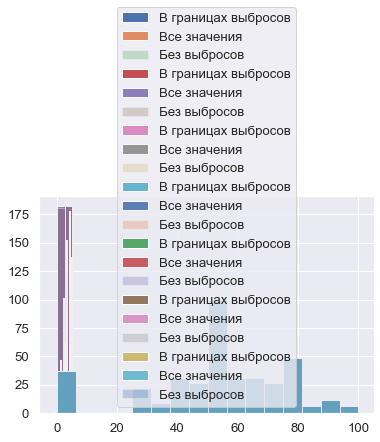

In [35]:
# Посмотрим, есть ли выбросы
for col in Ordinal:
    outliers(Ordinal, col)

<AxesSubplot:>

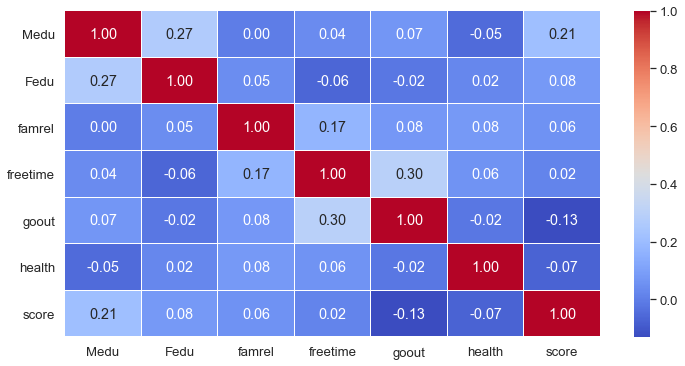

In [36]:
# Тепловая карта порядковых качественных переменных
sns.set(font_scale=1.2)
plt.subplots(figsize=(12, 6))
sns.heatmap(Ordinal.corr(), annot=True, fmt='.2f',
            linewidths=0.1, cmap="coolwarm")

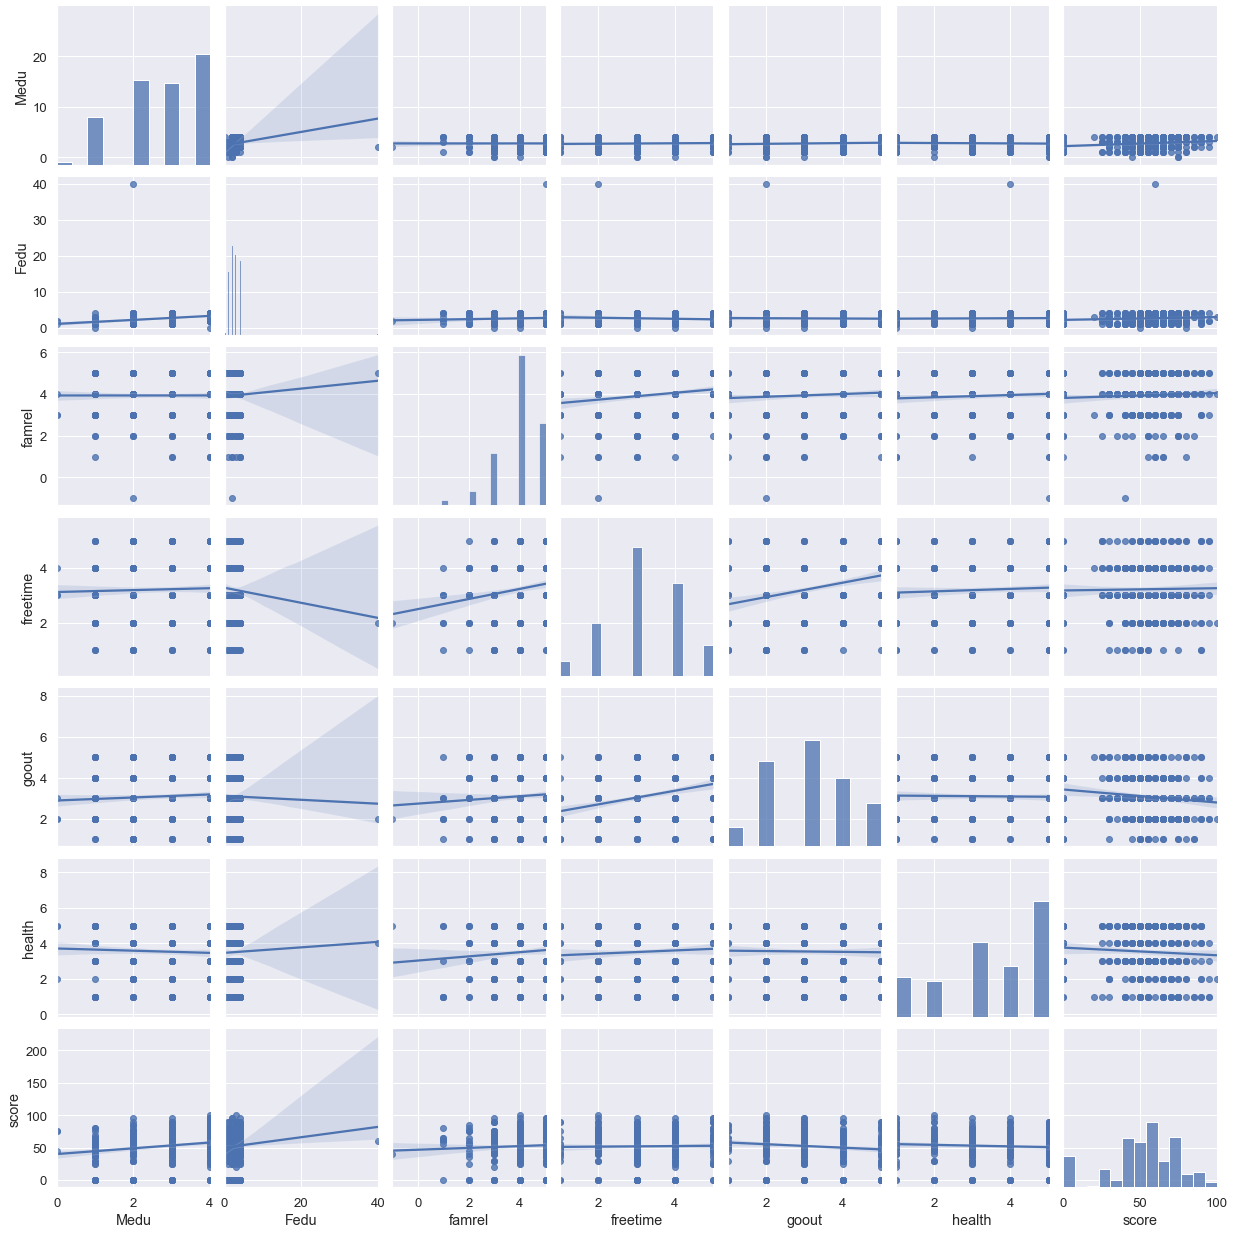

In [37]:
sns.pairplot(Ordinal, kind='reg')

In [38]:
Ordinal.corr()

,Medu,Fedu,famrel,freetime,goout,health,score
Medu,1.000000,0.270754,0.000602,0.038265,0.072320,-0.048331,0.213349
Fedu,0.270754,1.000000,0.045665,-0.062377,-0.019312,0.024861,0.078573
famrel,0.000602,0.045665,1.000000,0.174193,0.076387,0.080089,0.057112
freetime,0.038265,-0.062377,0.174193,1.000000,0.296338,0.064315,0.019026
goout,0.072320,-0.019312,0.076387,0.296338,1.000000,-0.018026,-0.129685
health,-0.048331,0.024861,0.080089,0.064315,-0.018026,1.000000,-0.070460
score,0.213349,0.078573,0.057112,0.019026,-0.129685,-0.070460,1.000000


In [39]:
# Есть небольшая корреляция с уровнем образования матери - Medu (зависимость почти
# в три раза сильнее чем с уровнем образования отца - Fedu)
# Небольшая обратная корреляция со временем, проведенным с друзьями - goout

meaningful.extend(['Medu', 'goout'])
meaningful

['age', 'failures', 'studytime', 'Medu', 'goout']

# Анализ номинативных качественных переменных

In [40]:
# Помимо оставшихся номинативных переменных: school, sex, address, famsize,
# Pstatus, Mjob, Fjob, reason, guardian, добабилась новая,преобразованная из
# количественной - absence_rate (как часто ученик пропускает занятия)

In [42]:
Nominal = stud[['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
                'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
                'nursery', 'higher', 'internet', 'romantic', 'absence_rate']]

Nominal

,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,absence_rate
0,GP,F,U,NaN,A,at_home,teacher,course,mother,yes,no,no,no,yes,yes,NaN,no,low
1,GP,F,U,GT3,NaN,at_home,other,course,father,no,yes,no,no,no,yes,yes,no,low
2,GP,F,U,LE3,T,at_home,other,other,mother,yes,no,NaN,no,yes,yes,yes,NaN,low
3,GP,F,U,GT3,T,health,NaN,home,mother,no,yes,yes,yes,yes,yes,yes,yes,low
4,GP,F,U,GT3,T,other,other,home,father,no,yes,yes,no,yes,yes,no,no,low
5,GP,M,U,LE3,T,services,other,reputation,mother,no,yes,yes,yes,yes,yes,yes,no,low
6,GP,M,NaN,LE3,T,other,other,home,mother,no,no,no,no,yes,yes,yes,no,low
7,GP,F,U,GT3,A,other,teacher,home,mother,yes,yes,no,no,yes,yes,no,no,low
8,GP,M,U,LE3,A,services,other,home,mother,no,yes,yes,no,yes,yes,yes,no,low
9,GP,M,U,NaN,NaN,other,other,home,mother,no,yes,yes,yes,yes,yes,yes,no,low


In [43]:
for col in Nominal: 
    uniq_nan(col)

Уникальных значений school: 2
Пустых значений school: 0.0%
Уникальных значений sex: 2
Пустых значений sex: 0.0%
Уникальных значений address: 2
Пустых значений address: 3.9%
Уникальных значений famsize: 2
Пустых значений famsize: 6.9%
Уникальных значений Pstatus: 2
Пустых значений Pstatus: 11.6%
Уникальных значений Mjob: 5
Пустых значений Mjob: 4.9%
Уникальных значений Fjob: 5
Пустых значений Fjob: 9.3%
Уникальных значений reason: 4
Пустых значений reason: 4.4%
Уникальных значений guardian: 3
Пустых значений guardian: 8.0%
Уникальных значений schoolsup: 2
Пустых значений schoolsup: 2.3%
Уникальных значений famsup: 2
Пустых значений famsup: 9.8%
Уникальных значений paid: 2
Пустых значений paid: 10.0%
Уникальных значений activities: 2
Пустых значений activities: 3.6%
Уникальных значений nursery: 2
Пустых значений nursery: 3.9%
Уникальных значений higher: 2
Пустых значений higher: 5.1%
Уникальных значений internet: 2
Пустых значений internet: 8.7%
Уникальных значений romantic: 2
Пустых зна

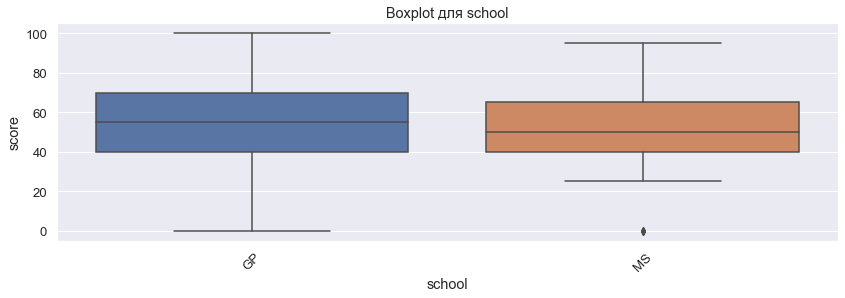

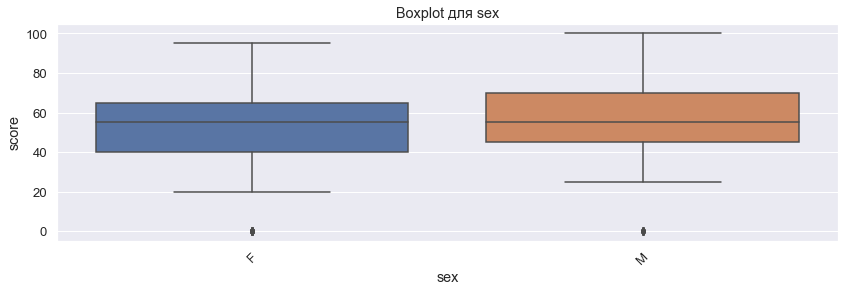

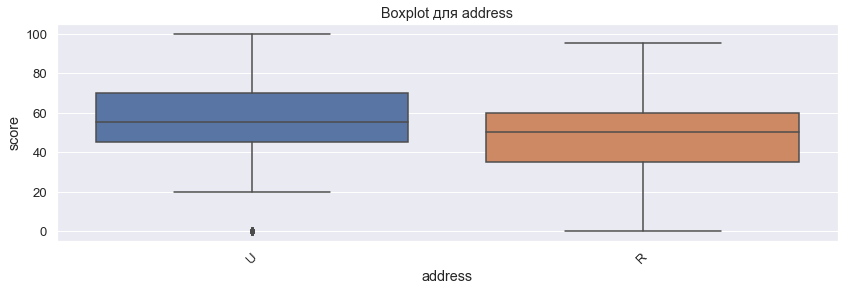

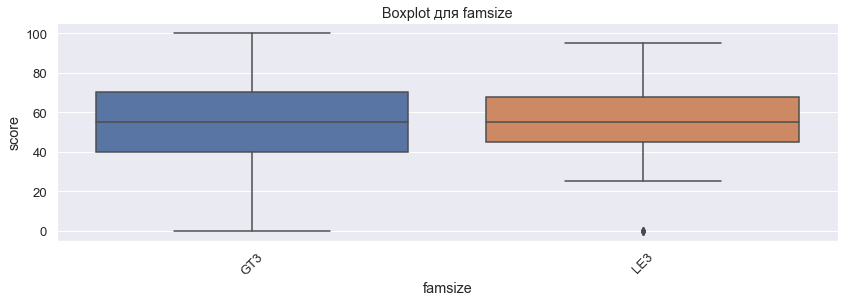

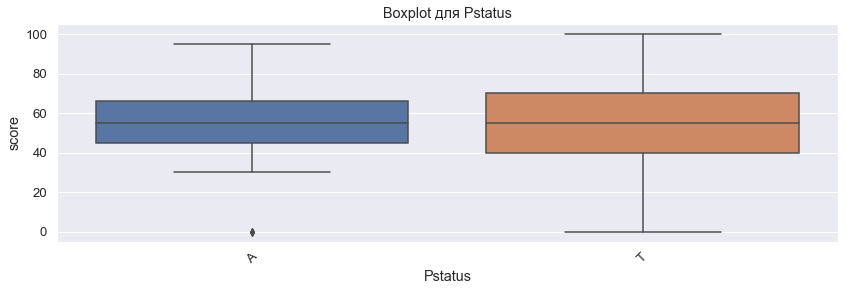

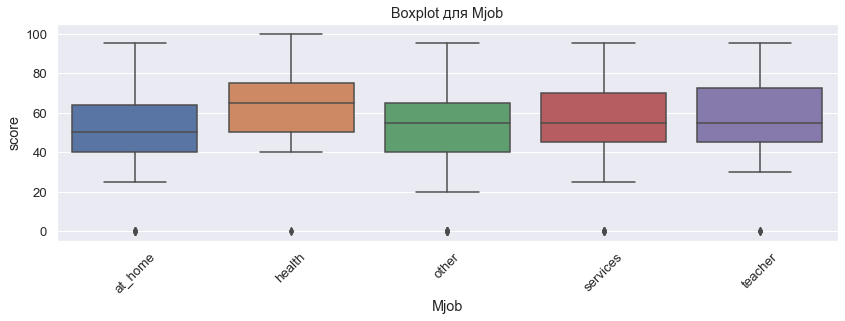

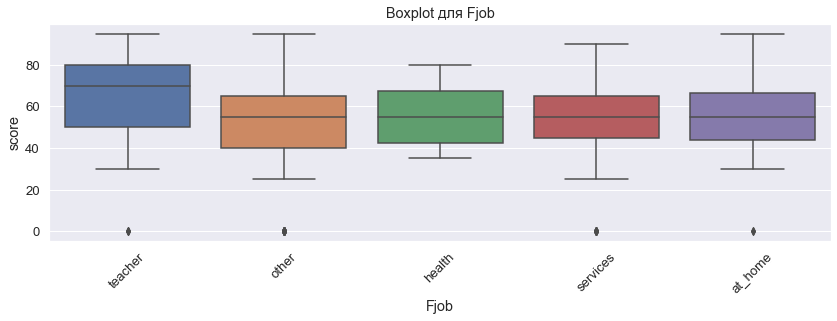

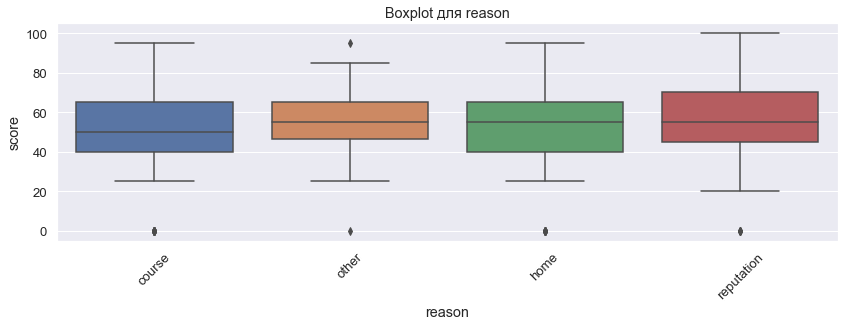

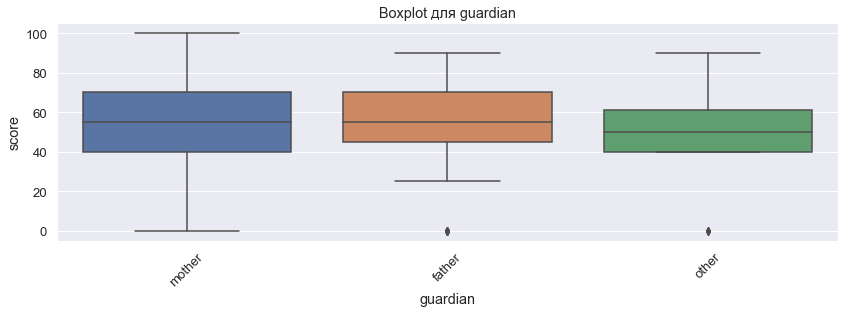

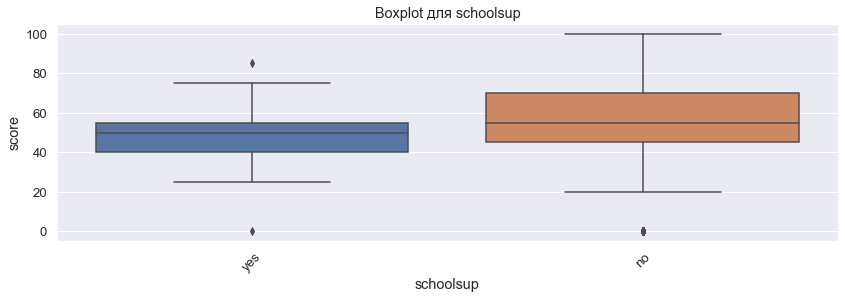

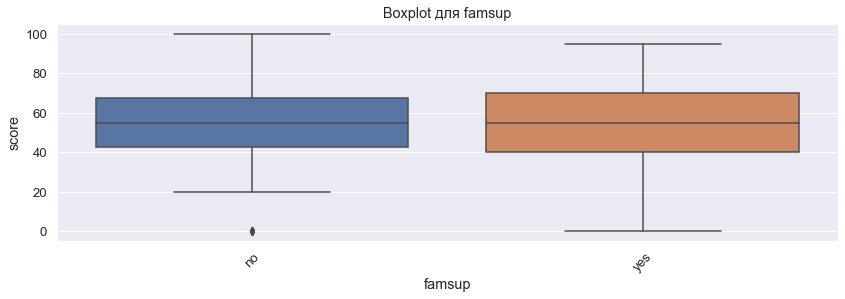

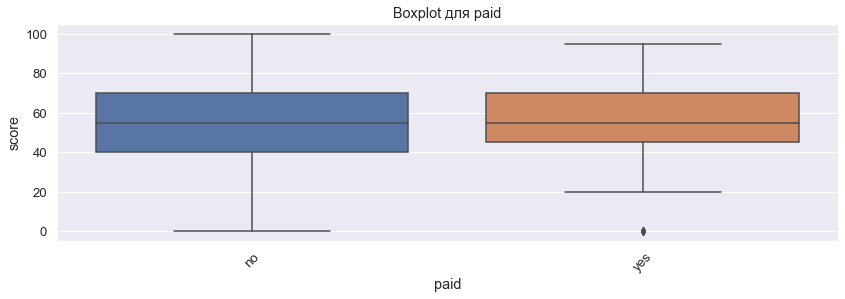

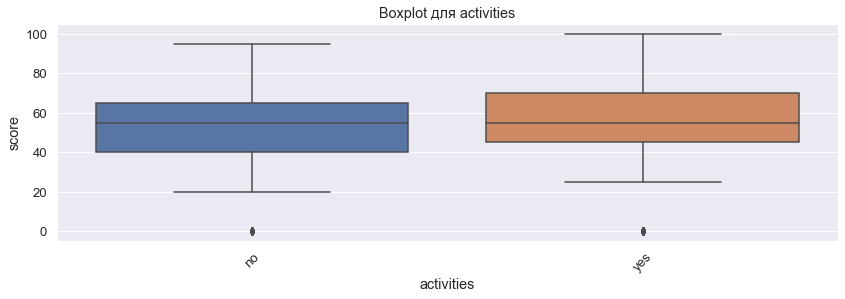

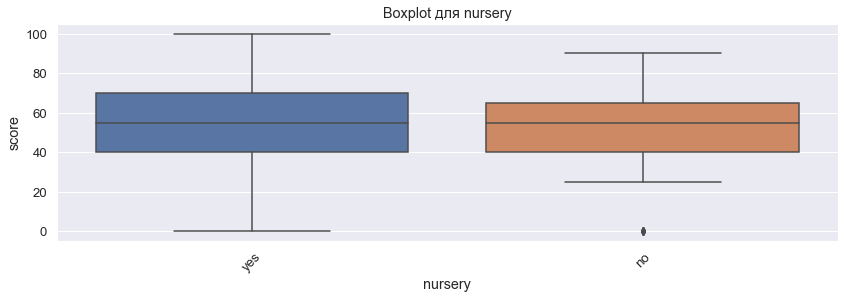

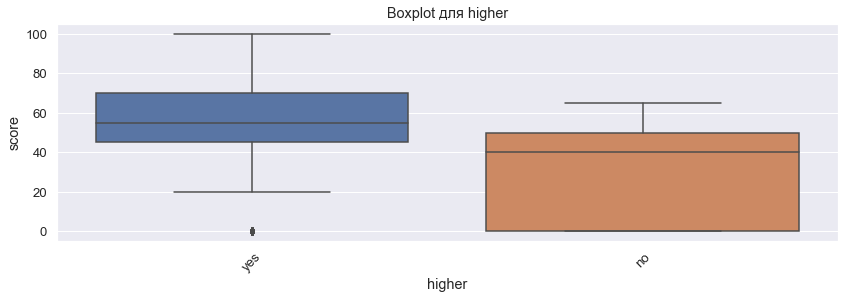

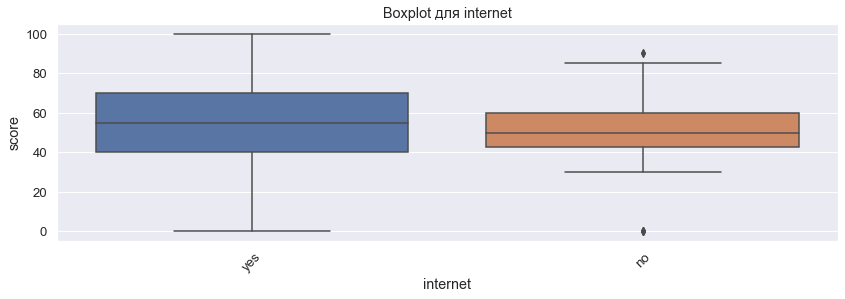

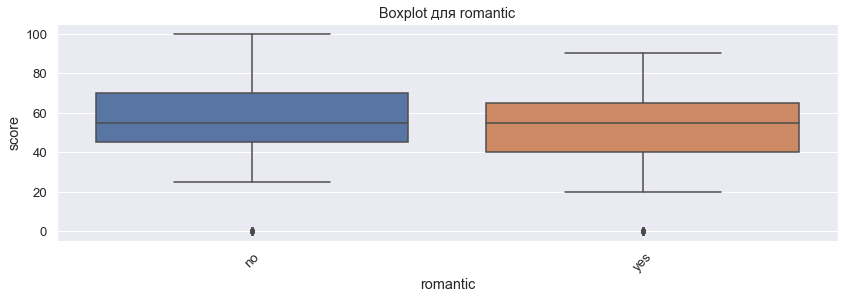

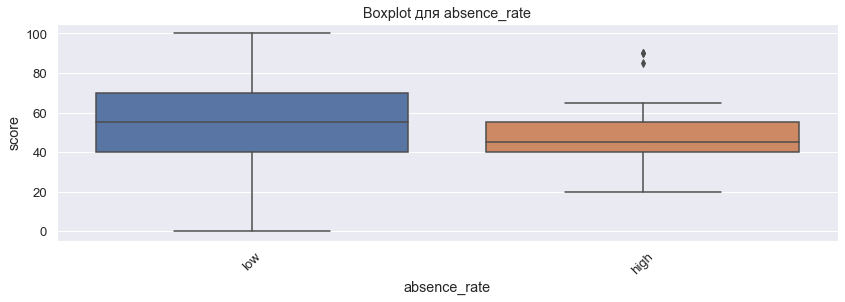

In [44]:
for col in Nominal: 
    get_boxplot(col)

In [45]:
# По графикам видно, что на количество баллов могут влиять:
#  school, sex, address, Mjob, Fjob, absences

In [46]:
# Проверим, есть ли статистическая разница в распределении
# оценок по номинативным признакам, с помощью теста Стьюдента.
for col in Nominal:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic


In [47]:
# Добавим значимые столбцы в список
meaningful.extend(['address', 'Mjob', 'higher', 'romantic'])

# Итого, получаем такие значимые столбцы
meaningful

['age',
 'failures',
 'studytime',
 'Medu',
 'goout',
 'address',
 'Mjob',
 'higher',
 'romantic']

# Итоги
Датасет не очень большой для качественного анализа - 395 строк

В данных были пустые значения, в дальнейшем нужно будет применять какие-то 

способы для аппроксимации этих пустых значений.


Выбросы были найдены в нескольких столбцах, я не стал их все устранять,


поскольку это могло сказатся на исследовании.  


Самые важные параметры, которые предлагается использовать в дальнейшем для построения модели, это:

age, failures, studytime, Medu, goout, address, Mjob, higher, romantic